In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from bertviz import model_view, head_view

In [52]:
print("GPU available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU available: True
GPU device name: NVIDIA GeForce GTX 1060


In [53]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
df = pd.read_json("data/full_format_recipes.json")
#df = pd.DataFrame(df)
nlp = spacy.load('en_core_web_md')

In [55]:
def process_category_text(text):
    """Process a single category text"""
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Lemmatize
    text = lemmatizer.lemmatize(text)

    text = word_tokenize(text)

    text = [w for w in text if w not in set(stopwords.words('english'))]
    
    return text


In [56]:
def process_category_list(text):
    """Process a list of categories with NaN handling"""
    # Handle NaN/None cases
    if isinstance(text, (float, type(None))):
        return []
    
    try:
        # Process each category in the list
        return [process_category_text(cat) for cat in text]
    except (TypeError, AttributeError):
        return []

In [57]:
df['processed_categories'] = df['directions'].apply(process_category_list)
#df['processed_directions'] = df["directions"].apply(process_category_list)

In [58]:
print(df[['directions', 'processed_categories']])
#print(df[['directions', 'processed_directions']])



                                              directions  \
0      [1. Place the stock, lentils, celery, carrot, ...   
1      [Combine first 9 ingredients in heavy medium s...   
2      [In a large heavy saucepan cook diced fennel a...   
3      [Heat oil in heavy large skillet over medium-h...   
4      [Preheat oven to 350°F. Lightly grease 8x8x2-i...   
...                                                  ...   
20125  [Beat whites in a bowl with an electric mixer ...   
20126  [Bring broth to simmer in saucepan.Remove from...   
20127  [Using a sharp knife, cut a shallow X in botto...   
20128  [Heat 2 tablespoons oil in heavy medium skille...   
20129  [Position rack in bottom third of oven and pre...   

                                    processed_categories  
0      [[place, stock, lentils, celery, carrot, thyme...  
1      [[combine, first, ingredients, heavy, medium, ...  
2      [[large, heavy, saucepan, cook, diced, fennel,...  
3      [[heat, oil, heavy, large, skillet, 

# BERT

In [59]:
# Process 'categories' column
def process_row(text):
    # Handle NaN, None, or non-list cases
    if not isinstance(text, list):
        return ""
    # Join list elements into a single string
    return " ".join(text)

categories_str = df["directions"].apply(process_row)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Tokenize the processed 'categories' column
# Convert the entire column to a single string (optional step)
combined_text = " ".join(categories_str)
input_ids = tokenizer.encode(combined_text, return_tensors="pt", max_length=512, truncation=True, return_attention_mask=True)

# Output the tokenized IDs
print(input_ids)

tensor([[  101,  1015,  1012,  2173,  1996,  4518,  1010, 15307, 12146,  1010,
          8292,  3917,  2100,  1010, 25659,  1010, 15177,  4168,  1010,  1998,
          5474,  1999,  1037,  5396, 12901,  9739,  1998,  3288,  2000,  1037,
         26077,  1012,  5547,  3684,  2000,  2659,  1998, 21934,  5017,  2127,
          1996, 15307, 12146,  2024,  8616,  1010,  2055,  2382,  2781,  1010,
          5834,  2006,  1996, 15307, 12146,  1012,  1006,  2065,  2027,  4088,
          2000,  4318,  2041,  1010,  5587,  2300,  2004,  2734,  1012,  1007,
          6366,  1998,  5860,  4232,  1996, 15177,  4168,  1012, 12475,  1998,
          4651,  1996,  8150,  2000,  1037,  4605,  1025,  2292,  4658,  1012,
          1016,  1012, 10671,  1999,  1996, 20856,  1010,  6207,  1010, 14380,
         10869,  1010,  1998,  9724,  3514,  1012,  2161,  2007,  1996, 11565,
          1012,  1017,  1012,  2000, 21365,  1037, 10236,  1010,  2173,  1015,
         13697,  4095,  7123,  2006,  1037,  4550,  

In [60]:
# Get the embeddings
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

# Extract the embeddings from the last hidden layer
last_hidden_states = outputs.last_hidden_state

# Get the [CLS] token embedding (first token)
cls_embedding = last_hidden_states[:, 0, :]


# Get document representations:
# 1. CLS token (document-level representation)
cls_vector = outputs.last_hidden_state[0, 0, :].numpy()

# 2. Mean of all token vectors (alternative document representation)
mean_vector = outputs.last_hidden_state[0].mean(dim=0).numpy()

# Process each document
document_vectors = []
vectors = []


cls_vector = outputs.last_hidden_state[0, 0, :].numpy()
vectors.append(cls_vector)

document_vectors.append({
    'cls_vector': cls_vector
    #, 'mean_vector': mean_vector
})

#print(input_ids)
#print(f"last_hidden_states: {last_hidden_states}")
#print(f"cls_embedding: {cls_embedding}")
#print(document_vectors)
print(cls_vector)
#print(f"input_ids['attention_mask']: {input_ids['attention_mask']}")
#print(f"input_ids: {input_ids['input_ids']}")
#print(f"tokens: {tokenizer.convert_ids_to_tokens(input_ids['input_ids'][0])}")

[-5.37056148e-01 -3.68132859e-01  6.42858386e-01  1.57642201e-01
 -2.06140399e-01 -7.00526297e-01 -1.20961621e-01  4.42805178e-02
 -7.90908337e-02 -7.77629375e-01 -2.81494409e-01  6.13863051e-01
  8.34170356e-02 -4.47195083e-01 -2.62662232e-01  4.44689393e-01
  3.95670325e-01 -5.83222583e-02  5.52590452e-02  2.49222055e-01
 -5.38799644e-01 -7.35625923e-01  7.95760632e-01  4.79486674e-01
  1.12277463e-01 -3.26312721e-01 -6.00848675e-01 -1.77829742e-01
 -9.88935381e-02 -6.50108084e-02  7.76198208e-02  5.02251744e-01
  5.57540432e-02 -6.56301320e-01  8.21281433e-01 -3.94469440e-01
  1.14060593e+00  3.64816904e-01  4.85887080e-01 -1.25568688e-01
 -5.58483064e-01  7.91331708e-01  5.19680262e-01 -7.88634062e-01
  4.10927355e-01  4.17448938e-01 -3.23971868e+00  2.00400576e-01
 -2.62359023e-01 -1.03262401e+00  3.59937727e-01 -5.66416740e-01
 -6.80129677e-02  2.52121240e-01  6.96469665e-01  4.33123887e-01
 -3.35453779e-01  5.99830627e-01  2.26571590e-01 -3.27991009e-01
 -2.73442030e-01  2.43469

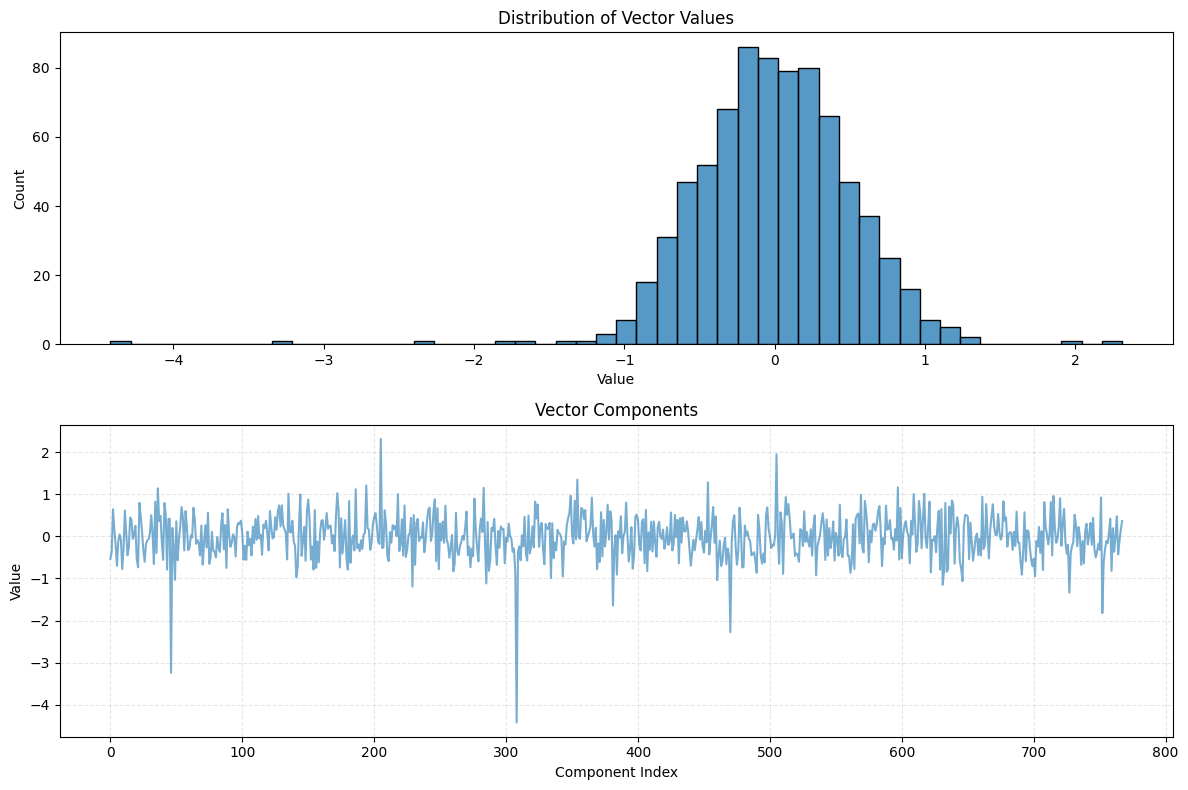

Dimensionality: 768
Mean: -0.0104
Median: -0.0146
Std Dev: 0.5260
Min: -4.4198
Max: 2.3105


In [61]:
# Create multiple visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 1. Distribution plot
sns.histplot(cls_vector, bins=50, ax=ax1)
ax1.set_title('Distribution of Vector Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

# 2. Component values plot
ax2.plot(range(len(cls_vector)), cls_vector, '-', alpha=0.6)
ax2.set_title('Vector Components')
ax2.set_xlabel('Component Index')
ax2.set_ylabel('Value')
ax2.grid(True, linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Dimensionality: {len(cls_vector)}")
print(f"Mean: {np.mean(cls_vector):.4f}")
print(f"Median: {np.median(cls_vector):.4f}")
print(f"Std Dev: {np.std(cls_vector):.4f}")
print(f"Min: {np.min(cls_vector):.4f}")
print(f"Max: {np.max(cls_vector):.4f}")

In [62]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move your model and tensors to GPU
#model = model.to(device)

# Get the tokens
#tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Plot the attention weights
#model_view(outputs.attentions, tokens)

# TF-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

In [64]:
# Convert categories into a format TF-IDF can process
docs = []
for categories in df['processed_categories']:
    if isinstance(categories, list):
        flattened = []
        for cat in categories:
            if isinstance(cat, list):
                flattened.extend(str(token) for token in cat)
            else:
                flattened.append(str(cat))
        docs.append(' '.join(flattened))

In [65]:
# Create TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(docs)

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

In [66]:
# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names
)

In [67]:
# Print full matrix info
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("\nComplete TF-IDF Matrix:")
print(tfidf_df)

TF-IDF Matrix Shape: (20130, 9681)

Complete TF-IDF Matrix:
       aaron  aash  abacela  abd  ablaze  able  abominated  absinthe  \
0        0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
1        0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
2        0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
3        0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
4        0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
...      ...   ...      ...  ...     ...   ...         ...       ...   
20125    0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
20126    0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
20127    0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
20128    0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   
20129    0.0   0.0      0.0  0.0     0.0   0.0         0.0       0.0   

       absolutely  absorb  ...  ziti  zombie  zone  zones   zs   zu  zucchi

In [68]:
# Show document-term statistics
print("\nTerm Statistics:")
for term in feature_names:
    non_zero_scores = tfidf_df[term][tfidf_df[term] > 0]
    if len(non_zero_scores) > 0:
        print(f"\nTerm: {term}")
        print(f"Number of documents containing term: {len(non_zero_scores)}")
        print(f"Average TF-IDF score: {non_zero_scores.mean():.4f}")
        print(f"Max TF-IDF score: {non_zero_scores.max():.4f}")


Term Statistics:

Term: aaron
Number of documents containing term: 1
Average TF-IDF score: 0.0592
Max TF-IDF score: 0.0592

Term: aash
Number of documents containing term: 1
Average TF-IDF score: 0.2044
Max TF-IDF score: 0.2044

Term: abacela
Number of documents containing term: 1
Average TF-IDF score: 0.1074
Max TF-IDF score: 0.1074

Term: abd
Number of documents containing term: 1
Average TF-IDF score: 0.5204
Max TF-IDF score: 0.5204

Term: ablaze
Number of documents containing term: 1
Average TF-IDF score: 0.1902
Max TF-IDF score: 0.1902

Term: able
Number of documents containing term: 16
Average TF-IDF score: 0.1132
Max TF-IDF score: 0.2364

Term: abominated
Number of documents containing term: 1
Average TF-IDF score: 0.1511
Max TF-IDF score: 0.1511

Term: absinthe
Number of documents containing term: 3
Average TF-IDF score: 0.3234
Max TF-IDF score: 0.4848

Term: absolutely
Number of documents containing term: 4
Average TF-IDF score: 0.0709
Max TF-IDF score: 0.0957

Term: absorb
N

# Word2Vec

In [71]:
# New cell
# Use the existing tokenizer from BERT to get word embeddings
def get_avg_word_embeddings(text_list):
    # Get the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Tokenize and get embeddings for each document
    doc_embeddings = []
    
    for doc in text_list:
        if isinstance(doc, list):
            # Join all words in the document
            text = ' '.join([str(word) for sublist in doc for word in (sublist if isinstance(sublist, list) else [sublist])])
            
            # Tokenize and move to device
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get embeddings using the last hidden state
            with torch.no_grad():
                outputs = model(**inputs)
            
            # Get average of all token embeddings (excluding special tokens)
            embeddings = outputs.last_hidden_state.squeeze(0)
            mask = inputs['attention_mask'].bool().squeeze(0)
            masked_embeddings = embeddings[mask]
            doc_vector = torch.mean(masked_embeddings, dim=0).cpu().numpy()
            
            doc_embeddings.append(doc_vector)
    
    return np.array(doc_embeddings)

# Get document vectors
#doc_vectors = get_avg_word_embeddings(df['processed_categories'])

In [72]:
# New cell - Visualize the results
#import matplotlib.pyplot as plt
#import seaborn as sns

# Create visualization of document vectors
#plt.figure(figsize=(20, 12))
#sns.heatmap(doc_vectors[:10], cmap='viridis')
#sns.heatmap(doc_vectors, cmap='viridis')
#plt.title('First 10 Document Vectors')
#plt.xlabel('Embedding Dimensions')
#plt.ylabel('Documents')
#plt.show()

# Print basic statistics
#print(f"Number of documents: {len(doc_vectors)}")
#print(f"Vector dimension: {doc_vectors.shape[1]}")
#print("\nFirst document vector (first 10 dimensions):")
#print(doc_vectors[0][:10])
#print(doc_vectors)

# Basic statistics
#print("\nBasic statistics:")
#print(f"Mean: {np.mean(doc_vectors):.4f}")
#print(f"Std: {np.std(doc_vectors):.4f}")
#print(f"Min: {np.min(doc_vectors):.4f}")
#print(f"Max: {np.max(doc_vectors):.4f}")

In [73]:
from gensim.models import Word2Vec
# Flatten the lists of lists to pass them to Word2Vec
sentences = df['processed_categories'].apply(lambda x: [item for sublist in x for item in sublist])

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)  # Skip-gram model

# Function to compute the document vector as the average of word embeddings
def compute_doc_vector(words, model):
    # Get vectors for words that are in the vocabulary
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words are in the vocab

# Compute document vectors for each processed_categories entry
df['doc_vector'] = sentences.apply(lambda x: compute_doc_vector(x, model))

# Show the document vectors
print(df[['processed_categories', 'doc_vector']])

                                    processed_categories  \
0      [[place, stock, lentils, celery, carrot, thyme...   
1      [[combine, first, ingredients, heavy, medium, ...   
2      [[large, heavy, saucepan, cook, diced, fennel,...   
3      [[heat, oil, heavy, large, skillet, medium, hi...   
4      [[preheat, oven, f, lightly, grease, x, x, inc...   
...                                                  ...   
20125  [[beat, whites, bowl, electric, mixer, hold, s...   
20126  [[bring, broth, simmer, saucepan, remove, heat...   
20127  [[using, sharp, knife, cut, shallow, x, bottom...   
20128  [[heat, tablespoons, oil, heavy, medium, skill...   
20129  [[position, rack, bottom, third, oven, preheat...   

                                              doc_vector  
0      [-0.034037698, 0.26798317, -0.15844133, -0.109...  
1      [-0.012615003, 0.3125653, -0.117480956, -0.163...  
2      [-0.19771536, 0.37062666, -0.08222468, -0.0781...  
3      [-0.19429936, 0.36271077, -0.1806434

# NEURAL NETWORKS pytorch

In [74]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [75]:
print(vectors)

[array([-5.37056148e-01, -3.68132859e-01,  6.42858386e-01,  1.57642201e-01,
       -2.06140399e-01, -7.00526297e-01, -1.20961621e-01,  4.42805178e-02,
       -7.90908337e-02, -7.77629375e-01, -2.81494409e-01,  6.13863051e-01,
        8.34170356e-02, -4.47195083e-01, -2.62662232e-01,  4.44689393e-01,
        3.95670325e-01, -5.83222583e-02,  5.52590452e-02,  2.49222055e-01,
       -5.38799644e-01, -7.35625923e-01,  7.95760632e-01,  4.79486674e-01,
        1.12277463e-01, -3.26312721e-01, -6.00848675e-01, -1.77829742e-01,
       -9.88935381e-02, -6.50108084e-02,  7.76198208e-02,  5.02251744e-01,
        5.57540432e-02, -6.56301320e-01,  8.21281433e-01, -3.94469440e-01,
        1.14060593e+00,  3.64816904e-01,  4.85887080e-01, -1.25568688e-01,
       -5.58483064e-01,  7.91331708e-01,  5.19680262e-01, -7.88634062e-01,
        4.10927355e-01,  4.17448938e-01, -3.23971868e+00,  2.00400576e-01,
       -2.62359023e-01, -1.03262401e+00,  3.59937727e-01, -5.66416740e-01,
       -6.80129677e-02, 

In [76]:
from sklearn.model_selection import train_test_split

X = cls_vector
Y = df["rating"].values

# Generate train and validation data, shuffle
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

ValueError: Found input variables with inconsistent numbers of samples: [768, 20130]

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm